# Visualizing Encoder Using PCA

Since the models in the last notebook don't take too long to train, a new model will be trained from scratch here. The objective in this notebook is to train this model as normal, but then attempt to create a visualization of the embedding vector. Ideally, this would allow the games and users to be catergorized by groups of interest.

The project starts by importing data, and defining a function to build a model, most which is copied from the last notebook. 

In [1]:
%matplotlib inline
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.special import expit
from timeit import default_timer
from sklearn.decomposition import PCA, KernelPCA



print("numpy version: ",np.__version__)
print("tensorflow version: ", tf.__version__)
print("keras version: ", keras.__version__)

numpy version:  1.18.5
tensorflow version:  2.3.0
keras version:  2.4.0


List available devices for tensorflow, to ensure GPU will be utilized (if you have one)

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

Copied set up of data from last notebook.

In [3]:
dtype_dict_games = {'buyer-count': 'int64',
 'player-count': 'int64',
 'accumulated-hours-played': 'float64',
 'player-frac-of-buyer': 'float64',
 'avg-hours-played': 'float64',
 'std-hours-played': 'float64'}

dtype_dict_users = {'purchased-game-count': 'int64',
 'played-game-count': 'int32',
 'played-hours-count': 'float64',
 'purhased-gametitles-list': 'object',
 'played-gametitles-list': 'object',
 'percent-library-played': 'float64',
 'played-hours-avg': 'float64',
 'played-hours-std': 'float64',
 'played-hours-max': 'float64',
 'most-played-game': 'object'}

games_stats_df = pd.read_csv('./steam_game_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_games)
users_stats_df = pd.read_csv('./steam_user_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_users)


#names to assign to columns
column_names = ['user-id','game-title','behavior-name','value']

#dtypes to assign
dtypes = {'user-id':int, 'game-title':str, 'behavior-name':'category', 'value':np.float64}

#read in data from csv (please adjust path if you want to run this). Dropped last column because useless
df = pd.read_csv('./steam-200k.csv', 
                usecols=[0,1,2,3],
                names=column_names)

#selects only play data (not purchase data)
play_mask = df['behavior-name'] == 'play'
play_df = df[play_mask]

#turn the full game list into list object to feed functions later
full_game_list = games_stats_df.index.to_list()
full_user_list = users_stats_df.index.to_list()

#instanciate label encoder
le = LabelEncoder()

#fit and transform the list of user-ids
pseudo_users = le.fit_transform(full_user_list)

#Store mapping into diction and dump content into pkl
pseudo_user_map = dict(zip(pseudo_users, le.classes_))
with open('./user_encoding_dict.pkl', 'wb') as file:
    pickle.dump(pseudo_user_map, file)

#repeat for games encoding
pseudo_games = le.fit_transform(full_game_list)    
pseudo_game_map = dict(zip(pseudo_games, le.classes_))
with open('./game_encoding_dict.pkl', 'wb') as file:
    pickle.dump(pseudo_game_map, file)

games_played_matrix = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    games_played_matrix.at[int(row['user-id']), row['game-title']] = 1

#the labels are changed after inputing the values
games_played_matrix.index = pseudo_users
games_played_matrix.columns = pseudo_games

#uplayed games get 0 value
for ind, row in games_played_matrix.iterrows():
    row.fillna(0, inplace=True)
    
#convert to scipy.sparse.dok_matrix
games_played_matrix_sparse = sparse.dok_matrix(games_played_matrix.values)

# Generate Training and Test data
user_input_data, game_input_data, labels_data = [],[],[]
num_users, num_games = games_played_matrix_sparse.shape
for (u, i) in games_played_matrix_sparse.keys():
    # positive instance
    user_input_data.append(float(u))
    game_input_data.append(float(i))
    labels_data.append(1.0)
    # negative instances, 4 choosen arbitrarily
    for t in range(4):
        j = np.random.randint(num_games)
        while games_played_matrix_sparse[u, j] == 1:
            j = np.random.randint(num_games)
        user_input_data.append(float(u))
        game_input_data.append(float(j))
        labels_data.append(0.0)

The code was adpated from the last journal, but adjusted to allow the embedding encoders to be extracted. This function will be able to accept users or games, for each respective encoder, and return the embedded vectors result.

In [4]:
def get_model(name = "", latent_dim = 100, fc_dim = 50):
    #Constant parameters for model
    model_name = "Neural_CF_" + name
    user_emb_name = "User_Embedding_" + name
    game_emb_name = "Game_Embedding_" + name
    latent_dim = 100
    fc_dim = 50

    #design input layer
    user_input = keras.Input(shape = (1,), name="user")
    game_input = keras.Input(shape = (1,), name="game")

    #create embeddings for vector representing user and their games played
    user_embeddings = layers.Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  embeddings_initializer="uniform", input_length=1)(user_input)
    game_embeddings = layers.Embedding(input_dim = num_games, output_dim = latent_dim, name = 'game_embedding',
                                  embeddings_initializer="uniform", input_length=1)(game_input)

    #add dropout to both embedding layers
    user_dropout = layers.Dropout(rate=.5, name='user_dropout')(user_embeddings)
    game_dropout = layers.Dropout(rate=.5, name='game_dropout')(game_embeddings)

    #flatten out results into one dimension
    user_latent = layers.Flatten(name = "user_flatten")((user_dropout))
    game_latent = layers.Flatten(name = "game_flatten")((game_dropout))

    #dot product of these latent vectors
    predict_vector = layers.Multiply(name = "dot_product")([user_latent, game_latent])

    #one hidden fully connected layer after dot product
    dense_layer = layers.Dense(fc_dim, name = "fully_connected", kernel_initializer = 'lecun_uniform', activation = 'relu')(predict_vector)

    #dropout after fully connected to help against overfitting
    dense_dropout = layers.Dropout(rate=.5, name = "fc_dropout")(dense_layer)

    #final dense layer
    prediction = layers.Dense(1, activation= 'sigmoid', kernel_initializer= 'lecun_uniform', name = 'predicition')(dense_dropout)

    #Build the model
    model = keras.Model(inputs = [user_input, game_input], outputs = prediction, name=model_name)
    user_emb = keras.Model(user_input, user_latent, name = user_emb_name)
    game_emb = keras.Model(game_input, game_latent, name = game_emb_name)
    
    #return all the full models and the parallel encoders
    return model, user_emb, game_emb

def train_model(model, batch_size = 100, epochs = 20, split = 0.2, verbose=1):
    #Setting the training hyperparameters for the model
    model.compile(loss='binary_crossentropy', 
                  optimizer = 'adam',
                  metrics = ["accuracy"])

    test_loss_scores = []
    test_accuracy_scores = []
    #Train the model, store metric scores
    for epoch in range(epochs):
        model.fit([np.array(user_train_input), np.array(game_train_input)],
                  np.array(Y_train),
                  batch_size = batch_size,
                  epochs = 1,
                  validation_split = split,
                  verbose = verbose)

        test_scores = model.evaluate([np.array(user_test_input), np.array(game_test_input)], np.array(Y_test), verbose = verbose)
        test_loss_scores.append(test_scores[0])
        test_accuracy_scores.append(test_scores[1])

    #inserts score into dataframe
    training_scores_df = pd.DataFrame([test_loss_scores, test_accuracy_scores], index = ['test_loss_scores', 'test_accuracy_scores']).T
    training_scores_df['epoch'] = training_scores_df.index
    
    #transforms for easy plotting via seaborn
    training_scores_df = pd.melt(training_scores_df, id_vars= 'epoch',
            value_vars = ['test_loss_scores', 'test_accuracy_scores'],
            var_name = 'score_type',
            value_name = 'score')

    #plot curve
    sns.lineplot(x= 'epoch', y= 'score', hue = 'score_type', data = training_scores_df)
    
    return training_scores_df

def printScoresTime(scores_df, start_time):
    
    #measure time difference and print
    time_elapse = default_timer() - start_time
    print("Training this model took ", time_elapse, " second(s)")
    
    #collect highest accurcy and lowest loss
    best_loss = scores_df['score'].min()
    best_accuracy = scores_df['score'].max()
    print("With the best loss score being: ", best_loss)
    print("With the best accuracy score being: ", best_accuracy)

Using train_test_split to sepereate tests and training data; the same as last notebook

In [5]:
from sklearn.model_selection import train_test_split
#zip user and game features together to allow train_test_split to split into training and testing data
user_game_input_data = list(zip(user_input_data, game_input_data))

#apply split
X_train, X_test, Y_train, Y_test = train_test_split(user_game_input_data, labels_data, test_size=0.2, random_state=42)

#split each X_train and X_test into user and game inputs again
user_train_input, game_train_input = map(list, zip(*X_train))
user_test_input, game_test_input = map(list, zip(*X_test))

First the Deep Learning model should be trained, and the resulting metrics are displayed on the graph as a function of epochs passed

Training this model took  1402.4091837  second(s)
With the best loss score being:  0.2794976830482483
With the best accuracy score being:  0.8926316499710083


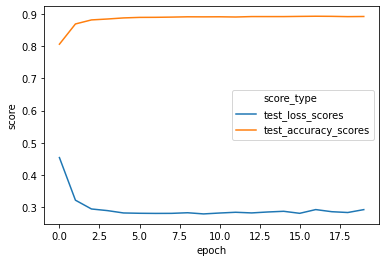

In [6]:
#call function to build model
model, user_emb, game_emb = get_model("4PCA")

#start time
start_time = default_timer()

#train model. reutrns scores dataframe
scores_df = train_model(model, batch_size = 50, verbose = 0)

#prints graph of scores over each epoch
printScoresTime(scores_df, start_time)

After training the model, use encoders to get the embedded vectors for all data points as discussed.

In [7]:
#use trained encoders to transform user and games into their embeddings
encoded_users = user_emb.predict(pseudo_users)
encoded_games = game_emb.predict(pseudo_games)

#print sumarry for both emdeddings
user_emb.summary()
print("""
-=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=-
""")
game_emb.summary()

Model: "User_Embedding_4PCA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user (InputLayer)            [(None, 1)]               0         
_________________________________________________________________
user_embedding (Embedding)   (None, 1, 100)            1239300   
_________________________________________________________________
user_dropout (Dropout)       (None, 1, 100)            0         
_________________________________________________________________
user_flatten (Flatten)       (None, 100)               0         
Total params: 1,239,300
Trainable params: 1,239,300
Non-trainable params: 0
_________________________________________________________________

-=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=--=|=-

Model: "Game_Embedding_4PCA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g

Next, before lowering the dimensionality of the vectors, a clustering algorigthm will be used to give group labels. After a bit of reading online, the advice seemed to point to K-means cluster for data that is high in dimensionality (100 len vectors). Since it's unclear how many clusters there should be, the "elbow" method will be envoked. This entails collecting the metric score after training a model of various sizes. These values are then plotted on a graph, and the developer can choose a value near the bottom of the bend to retrain on.

<AxesSubplot:xlabel='No_of_Clusters', ylabel='Intertia'>

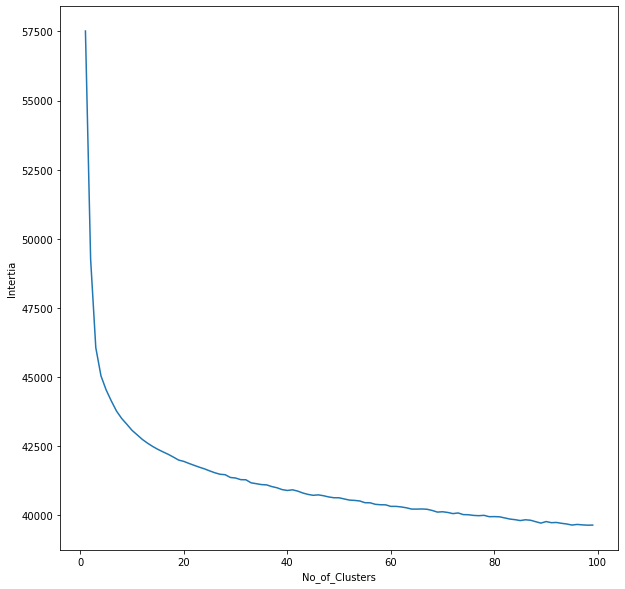

In [8]:
#prepare empty data frame for metrics
KmeanElbow_df = pd.DataFrame(columns=["No_of_Clusters", "Interia"])

#train and evaluate each model to determined best # of clusters: elbow method
for n_clusters in range(1,100):
    kmean = KMeans(n_clusters = n_clusters)

    km_user = kmean.fit(encoded_users)

    KmeanElbow_df = KmeanElbow_df.append({"No_of_Clusters": n_clusters, "Intertia": km_user.inertia_}, ignore_index=True)
    
plt.rcParams['figure.figsize']=(10,10)

sns.lineplot(data=KmeanElbow_df, x="No_of_Clusters", y="Intertia")


<AxesSubplot:xlabel='No_of_Clusters', ylabel='Intertia'>

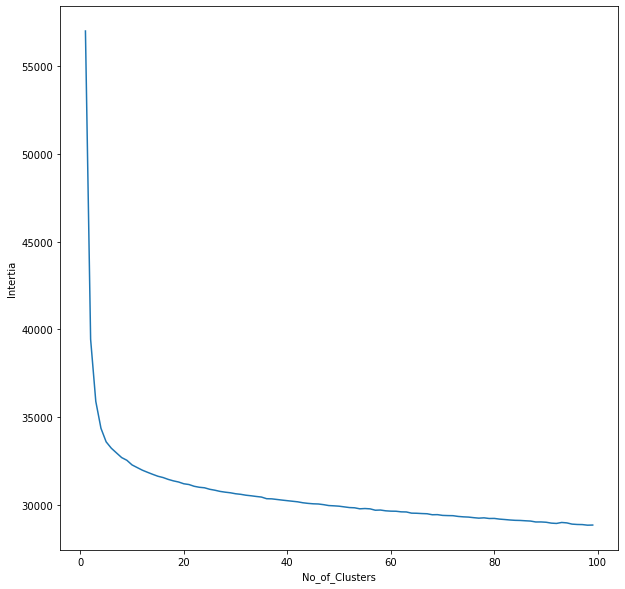

In [10]:
#same thing as users
KmeanElbow_df = pd.DataFrame(columns=["No_of_Clusters", "Interia"])

for n_clusters in range(1,100):
    kmean = KMeans(n_clusters = n_clusters)

    km_game = kmean.fit(encoded_games)

    KmeanElbow_df = KmeanElbow_df.append({"No_of_Clusters": n_clusters, "Intertia": km_game.inertia_}, ignore_index=True)
    
plt.rcParams['figure.figsize']=(10,10)

sns.lineplot(data=KmeanElbow_df, x="No_of_Clusters", y="Intertia")


For the Users, the elbow occured at approximately 20 number of clusters, and for the Games, the elbow occured at approximately 15 number of clusters. Two new cluster models are trained with those parameters.

In [14]:
#retrain using "elbow" value
kmean = KMeans(n_clusters = 20)

#turn users into categories based on clustering
km_user = kmean.fit(encoded_users)

Next, the dimensions of the embedded vectors will be dropped down to 2-D using Principal Component Analysis (PCA). This allows these vectors to be grpahed on a 2-D plane. The cluster labels were added in to see if points in the same cluster would end up near each other as expected.

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

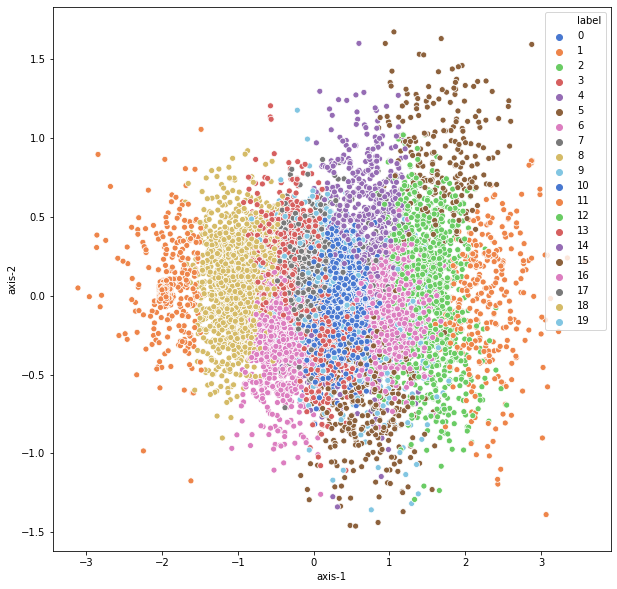

In [18]:
#turn down dimensionality of embeddings to 2, put into data frame, add label from clustering
pca = PCA(n_components= 2)
user_pca = pca.fit_transform(encoded_users)
user_vec_df = pd.DataFrame(user_pca, columns=['axis-1', 'axis-2'])
user_vec_df["label"] = km_user.predict(encoded_users)

#plot results
plt.rcParams['figure.figsize']=(10,10)
sns.scatterplot(data=user_vec_df, x='axis-1', y='axis-2', hue='label', palette="muted")

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

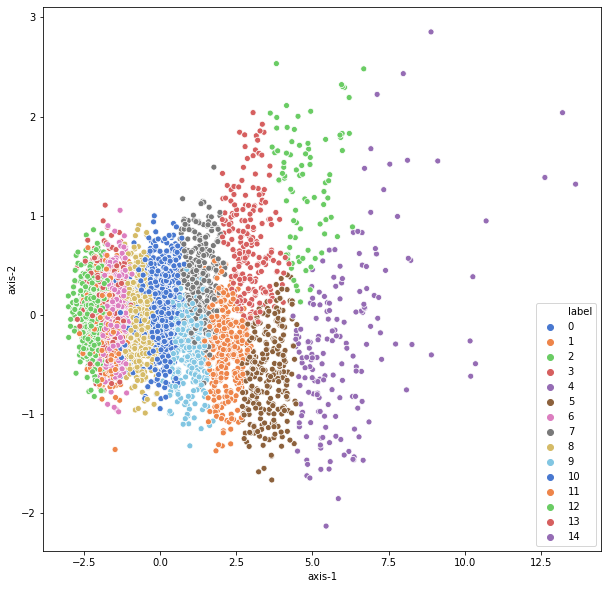

In [19]:
#repeated methodology as for users
kmean = KMeans(n_clusters = 15)

km_game = kmean.fit(encoded_games)

pca = PCA(n_components= 2)
game_pca = pca.fit_transform(encoded_games)
game_vec_df = pd.DataFrame(game_pca, columns=['axis-1', 'axis-2'])
game_vec_df["label"] = km_game.predict(encoded_games)

plt.rcParams['figure.figsize']=(10,10)
sns.scatterplot(data=game_vec_df, x='axis-1', y='axis-2', hue='label', palette="muted")

The results are decent for both users and games, there are clearly groups of colors, but borders are a bit overlapped.

The game's results look a bit better that the users (hueristically could be explain by games being more "defined" than a human's prefrences). In both situation, the labels are more dependent on axis-1 than axis-2 

In this next cell, a kernel PCA will be used instead to invetigate potentially better results. PCA can only reduce correctly under the assumption that the dimensions have linear relationships. What kernal PCA can get around this by actually increasing the dimensionality first, and then dropping back down. Non-linear relation ships can be projected into linear relationships in a higher dimension before proceeding with PCA. The default kernel is linear.

<AxesSubplot:xlabel='axis-1', ylabel='axis-2'>

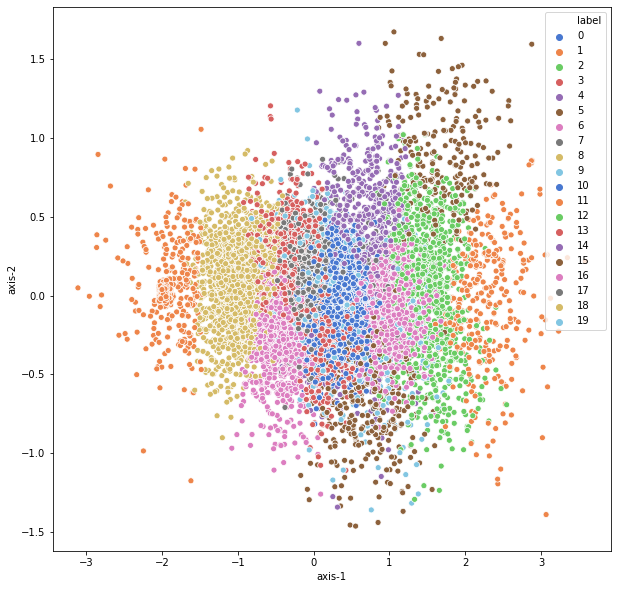

In [23]:
#switch from pca to kernel pca. Use default kernel
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components= 2)
user_kpca = pca.fit_transform(encoded_users)
user_kvec_df = pd.DataFrame(user_kpca, columns=['axis-1', 'axis-2'])
user_kvec_df["label"] = km_user.predict(encoded_users)

sns.scatterplot(data=user_kvec_df, x='axis-1', y='axis-2', hue="label", palette="muted")

"Linear" kernel seems to give equivalent result as PCA. Next the available kernels will be interated through to test results.

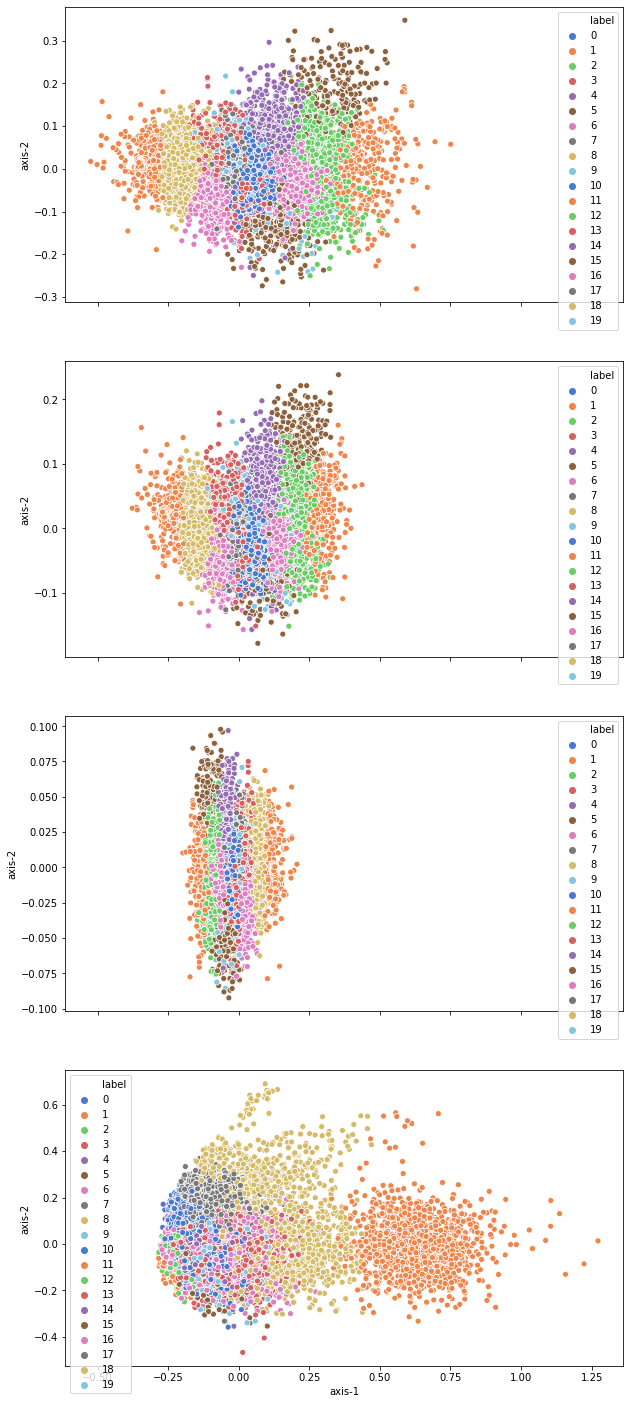

In [28]:
#prepare list of possible kernals
kernels = ["poly", "rbf", "sigmoid", "cosine"]

fig, axes = plt.subplots(4, sharex=True, figsize = (10,25))

#plot users kpca with cluster labeling.
for ax, kern in zip(axes, kernels):
    kpca = KernelPCA(n_components= 2, kernel=kern)
    user_kpca = kpca.fit_transform(encoded_users)
    user_kvec_df = pd.DataFrame(user_kpca, columns=['axis-1', 'axis-2'])
    user_kvec_df["label"] = km_user.predict(encoded_users)

    sns.scatterplot(data=user_kvec_df, x='axis-1', y='axis-2', hue="label", palette="muted", ax=ax)

Looking at the results, "poly", "rbf", and "sigmoid" all give similar results, but compressed on axis-1, except for "cosine", which gives a much different resutl, but it looks worse. That conclusion was reached because some cluster gain much more space than others, which doesn't seem appropriate.

# Application

From here, this PCA vector space could used in a decision tree, ideally using the default PCA. This is a a trypical use case of a unsupervised model such as clustering. But by confirming that PCA can "encode" similar details as the clustering, a decision tree can be used using 2-D instead of 100, which would likely yield better result. From prior experience, I know feeding too high dimensional data into decision trees may lead to poor prediction power.